## 2. A, C and Z frequency weightings

After we compensate the input signal by means of the designed inverse filter, the next step is to pass its output to the **frequency weighting network**.

The purpose of these frequency weighting networks is to adapt the measurements results to the **natural behaviour of the human ear**. As we know, **the relationship between the subjective perception of sound intensity (loudness) and the actual sound pressure level is not linear throughout the frequency spectrum**. We are more sensitive in the frequency range from around 500 Hz to 6 kHz. Moreover, **this behaviour varies with the actual sound pressure level of the signal**.

The **A frequency weighting** provides a way to take into account the loudness percieved throughout the frequency spectrum as compared to a **1 kHz tone at 40 dBSPL**, this is know as **40 fons**. On the other hand, the **C frequency weighting** applies the same logic but at a **100 fon** level. As for the **Z frequency weighting** well, it actually means no weighting at all ¯\\_(ツ)_/¯.

## Designing the filters

The frequency weighitngs that are used on sound level meters are defined in the **IEC 61672 standard**. In it the tolerance limits are defined for the three mentioned weightings, as well as the **procedure to correctly design them**.

The standard specifies the **transfer function** that describes each filter, for the case of the **A weighting filter** this is:

$$A(s)= \dfrac{1.2589049 \ x \ 76617.2^2s^4}{(s + 129.43)^2(s + 676.7)(s + 4636.36)(s + 76617.2)^2}$$

Since this equation is given in the **analog complex-frequency _s_-domain** we need to map that to the **_z_ digital domain**. This is done through the **Laplace transform** and applying the **bilinear transform**. This way we can then **implement a digital filter based on this equation**.

The **digital filter** will be **defined by the location of the poles and zeros the within the unit-circle**. We'll define the **zero-pole-gain system** for the **A and C frequency weightings**, as extracted from the standard and do the necessary steps to obtain our digital filters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

## Zero-pole-gain system calculated
## from the IEC 61672 standard
## - - - - - - - - - - - - - - -

# C weighting
Z_C = np.array([0, 0])
P_C = np.array([-2*np.pi*20.598997057568145, 
                -2*np.pi*20.598997057568145,
                -2*np.pi*12194.21714799801,
                -2*np.pi*12194.21714799801])
K_C = (10**(0.062/20))*P_C[3]**2

# A weighting
Z_A = np.append(Z_C, [0, 0])
P_A = np.insert(P_C, 
                [2, 2], 
                [-2*np.pi*107.65264864304628, 
                -2*np.pi*737.8622307362899])
K_A = (10**(2/20))*P_A[4]**2

Having our **zero-pole-gain systems** we can start to design the filters. As we can see **the coefficients for the A weighting filter draw from the ones given for the C weighting**.

## Plotting the curves

First, before doing the transformation from the analog _s_-domain to the digital _z_-domain, let's plot the filters as defined in the standard.

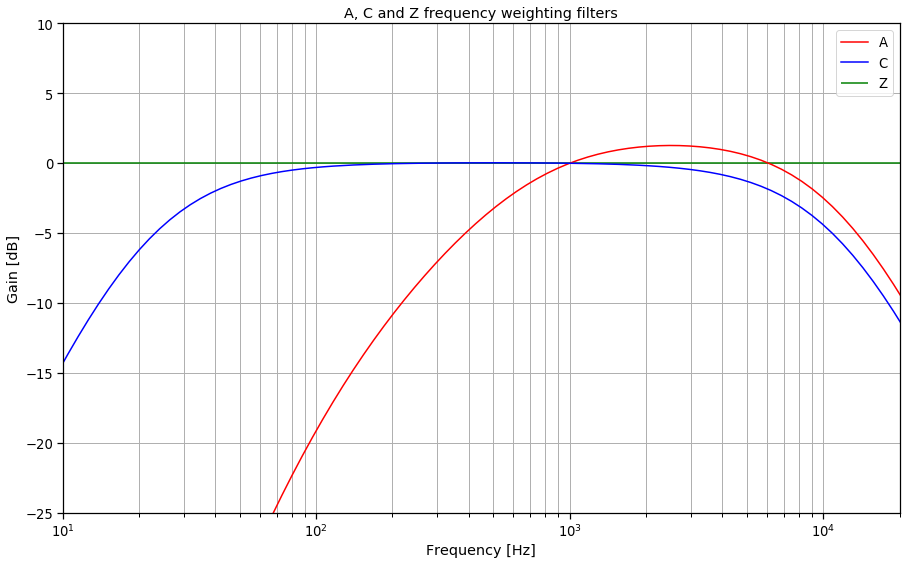

In [28]:
from scipy.signal import freqs_zpk

W_A, H_A = freqs_zpk(Z_A, P_A, K_A)
W_C, H_C = freqs_zpk(Z_C, P_C, K_C)

plt.plot(W_A/(2*np.pi), 20*np.log10(abs(H_A)), color='r', label='A')
plt.plot(W_C/(2*np.pi), 20*np.log10(abs(H_C)), color='b', label='C')
plt.hlines(y=0, xmin=0, xmax=10**5, color='g', label='Z')

plt.xscale('log')
plt.title('A, C and Z frequency weighting filters')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.legend()
plt.grid('on', which='both')
plt.ylim([-25, 10])
plt.xlim([10, 20000]);

Above, we can see clearly the **effect of each weighting filter on the signal**. 

The **A weighting filter is the most common in acoustical measurements**, and as displayed it **under-estimates the lower end of the frequency spectrum, giving more importance to the frequencies from 1 kHz to 6 kHz**. The **C weighting filter, that follows the response of the ear at higher sound pressure levels, has a gentler pass-band curve as it has an almost linear response between 100 Hz and 2 kHz**.

## From the analog to the digital domain

Next, we'll **define and apply the bilinear transformation that will allow us to design a digital filter** based on the provided transfer function.

In [31]:
def bilinear_zpk(z, p, k, fs=44100):
    """ Returns the zero-pole-gain system in the z-domain
    from the same system in the s-domain through the bilinear
    transform. """
    deg = len(p) - len(z)
    fs2 = 2.0*fs
    # Bilinear transform
    z_b = (fs2 + z)/(fs2 - z)
    p_b = (fs2 + p)/(fs2 - p)
    z_b = np.append(z_b, -np.ones(deg))
    k_b = k*np.real(np.prod(fs2 - z)/np.prod(fs2 - p))
    return z_b, p_b, k_b

Now, let's get transform our zero-pole-gain system from the _s_-plane to the _z_ unit circle. After that we can calculate **the coefficients to apply this zero-pole-gain system as a filter in cascading second-order-sections**.

In [39]:
from scipy.signal import zpk2sos

sos_A = zpk2sos(*bilinear_zpk(z_a, p_a, k_a))
sos_C = zpk2sos(*bilinear_zpk(z_c, p_c, k_c))

# saving
#np.save('../src/sos_A.npy', sos_A)
#np.save('../src/sos_C.npy', sos_C)

We have our coefficients, awesome! Now we can define two simple functions to apply the A and C frequency weighting filters.

In [40]:
def filt_A(x):
    """ Applies the A weighting filter to the input signal 'x' """
    return sosfilt(sos_A, x)

def filt_C(x):
    """ Applies the C weighting filter to the input signal 'x' """
    return sosfilt(sos_C, x)